In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

## Prepare data

### train data

In [2]:
DATA_PATH = './data/'
train_df = pd.read_csv(DATA_PATH + 'train_cleaned.csv')

In [3]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,105,0,2016-01-01 00:00:00,23.3036,1,Education,50623,NaN,5.0
1,106,0,2016-01-01 00:00:00,0.3746,1,Education,5374,NaN,4.0
2,106,3,2016-01-01 00:00:00,0.0000,1,Education,5374,NaN,4.0
3,107,0,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0
4,108,0,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0


### Building metadata

In [4]:
building_df = pd.read_csv(DATA_PATH + 'building_metadata.csv')

In [5]:
building_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
len(building_df['square_feet'].unique())

1397

In [7]:
len(building_df['building_id'].unique())

1449

In [8]:
def building_preprocess(df):
    df.drop(["year_built", "floor_count"], axis=1, inplace=True)
    le = LabelEncoder()
    df.primary_use = le.fit_transform(df.primary_use)

    del le
    gc.collect()

In [9]:
building_preprocess(building_df)

In [10]:
building_df.head()

,site_id,building_id,primary_use,square_feet
0,0,0,0,7432
1,0,1,0,2720
2,0,2,0,5376
3,0,3,0,23685
4,0,4,0,116607


In [11]:
building_preprocess(train_df)

In [12]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet
0,105,0,2016-01-01 00:00:00,23.3036,1,0,50623
1,106,0,2016-01-01 00:00:00,0.3746,1,0,5374
2,106,3,2016-01-01 00:00:00,0.0000,1,0,5374
3,107,0,2016-01-01 00:00:00,175.1840,1,0,97532
4,108,0,2016-01-01 00:00:00,91.2653,1,0,81580


### weather metadata

In [13]:
weather_df = pd.read_csv(DATA_PATH + 'weather_train.csv')

In [14]:
weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [15]:
def weather_preprocess(df):
    df.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
    df = df.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
    return df

In [16]:
weather_df = weather_preprocess(weather_df)

In [17]:
weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0


#### Merge above three datasets

In [18]:
#train_df = train_df.merge(building_df, on='building_id')
train_df = train_df.merge(weather_df, on=['site_id','timestamp'], how='left')

In [19]:
train_df.timestamp = pd.to_datetime(train_df.timestamp, format='%Y-%m-%d %H:%M:%S')
train_df["log_meter_reading"] = np.log1p(train_df.meter_reading)

In [20]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,log_meter_reading
0,105,0,2016-01-01,23.3036,1,0,50623,3.8,0.0,2.4,NaN,3.190624
1,106,0,2016-01-01,0.3746,1,0,5374,3.8,0.0,2.4,NaN,0.318163
2,106,3,2016-01-01,0.0000,1,0,5374,3.8,0.0,2.4,NaN,0.000000
3,107,0,2016-01-01,175.1840,1,0,97532,3.8,0.0,2.4,NaN,5.171529
4,108,0,2016-01-01,91.2653,1,0,81580,3.8,0.0,2.4,NaN,4.524668


In [21]:
del weather_df
gc.collect()

100

In [22]:
print(len(train_df['building_id'].unique()))

1447


## Reduce memory

In [23]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [24]:
train_df = reduce_mem_usage(train_df,use_float16=True)
# weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 1929.65 MB
Memory usage after optimization is: 723.62 MB
Decreased by 62.5%


In [25]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,log_meter_reading
0,105,0,2016-01-01,23.303600,1,0,50623,3.800781,0.0,2.400391,NaN,3.191406
1,106,0,2016-01-01,0.374600,1,0,5374,3.800781,0.0,2.400391,NaN,0.318115
2,106,3,2016-01-01,0.000000,1,0,5374,3.800781,0.0,2.400391,NaN,0.000000
3,107,0,2016-01-01,175.184006,1,0,97532,3.800781,0.0,2.400391,NaN,5.171875
4,108,0,2016-01-01,91.265297,1,0,81580,3.800781,0.0,2.400391,NaN,4.523438


## Feature engineering

### Creating time-based features

In [26]:
def add_timebase_features(df):
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    return df

In [27]:
train_df = add_timebase_features(train_df)

In [28]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,log_meter_reading,hour,weekend
0,105,0,2016-01-01,23.303600,1,0,10.832181,3.800781,0.0,2.400391,NaN,3.191406,0,4
1,106,0,2016-01-01,0.374600,1,0,8.589514,3.800781,0.0,2.400391,NaN,0.318115,0,4
2,106,3,2016-01-01,0.000000,1,0,8.589514,3.800781,0.0,2.400391,NaN,0.000000,0,4
3,107,0,2016-01-01,175.184006,1,0,11.487946,3.800781,0.0,2.400391,NaN,5.171875,0,4
4,108,0,2016-01-01,91.265297,1,0,11.309352,3.800781,0.0,2.400391,NaN,4.523438,0,4


In [29]:
train_df.tail()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,log_meter_reading,hour,weekend
19455577,1444,0,2016-12-31 23:00:00,8.750000,15,1,9.884305,1.700195,2.0,-5.601562,-1.0,2.277344,23,5
19455578,1445,0,2016-12-31 23:00:00,4.825000,15,0,8.366138,1.700195,2.0,-5.601562,-1.0,1.761719,23,5
19455579,1446,0,2016-12-31 23:00:00,0.000000,15,1,9.329545,1.700195,2.0,-5.601562,-1.0,0.000000,23,5
19455580,1447,0,2016-12-31 23:00:00,159.574997,15,4,10.301458,1.700195,2.0,-5.601562,-1.0,5.078125,23,5
19455581,1448,0,2016-12-31 23:00:00,2.850000,15,6,11.432496,1.700195,2.0,-5.601562,-1.0,1.347656,23,5


## Features & Target Variables

In [30]:
target = train_df["log_meter_reading"]
features = train_df.drop(['timestamp', 'meter_reading', 'log_meter_reading', 'building_id', 'site_id'], axis=1)
del train_df
gc.collect()

162

## KFOLD LIGHTGBM Model

In [31]:
categorical_features = ["meter", "primary_use", "hour", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]

    test_features = features.loc[test_index]
    test_target = target.loc[test_index]

    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training, d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/Users/lifa08/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.17157	valid_1's rmse: 1.25074
[50]	training's rmse: 0.975886	valid_1's rmse: 1.09628
[75]	training's rmse: 0.901403	valid_1's rmse: 1.0488
[100]	training's rmse: 0.863124	valid_1's rmse: 1.03006
[125]	training's rmse: 0.837825	valid_1's rmse: 1.02035
[150]	training's rmse: 0.82095	valid_1's rmse: 1.01609
[175]	training's rmse: 0.808444	valid_1's rmse: 1.01303
[200]	training's rmse: 0.798281	valid_1's rmse: 1.01101
[225]	training's rmse: 0.79035	valid_1's rmse: 1.00982
[250]	training's rmse: 0.784298	valid_1's rmse: 1.00915
[275]	training's rmse: 0.779112	valid_1's rmse: 1.00879
[300]	training's rmse: 0.774116	valid_1's rmse: 1.00842
[325]	training's rmse: 0.769013	valid_1's rmse: 1.00785
[350]	training's rmse: 0.764853	valid_1's rmse: 1.00763
[375]	training's rmse: 0.760902	valid_1's rmse: 1.00742
[400]	training's rmse: 0.756276	valid_1's rmse: 1.00687
[425]	training's rmse: 0.751682	valid_1's rmse: 1.

In [32]:
del features, target
gc.collect()

20

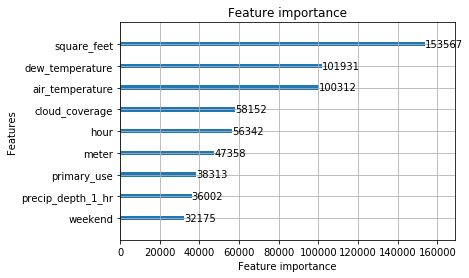

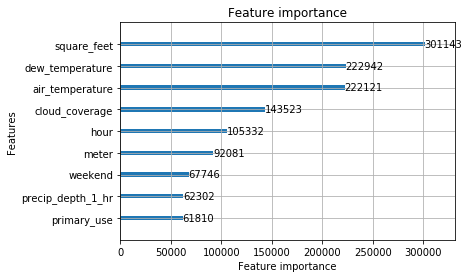

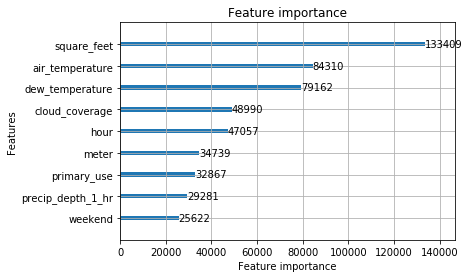

In [33]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

## Predict

In [34]:
test_df = pd.read_csv(DATA_PATH + 'test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)

In [35]:
building_df = pd.read_csv(DATA_PATH + 'building_metadata.csv')

In [36]:
test_df = test_df.merge(building_df, on='building_id', how='left')
test_df.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN
1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN
2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN
3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN
4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN


In [37]:
building_preprocess(test_df)

In [38]:
test_df.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet
0,0,0,2017-01-01 00:00:00,0,0,7432
1,1,0,2017-01-01 00:00:00,0,0,2720
2,2,0,2017-01-01 00:00:00,0,0,5376
3,3,0,2017-01-01 00:00:00,0,0,23685
4,4,0,2017-01-01 00:00:00,0,0,116607


In [39]:
weather_test_df = pd.read_csv(DATA_PATH + 'weather_test.csv')
weather_test_df = weather_preprocess(weather_test_df)

In [40]:
test_df = test_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')
test_df.timestamp = pd.to_datetime(test_df.timestamp, format='%Y-%m-%d %H:%M:%S')

test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 3499.40 MB
Memory usage after optimization is: 1630.40 MB
Decreased by 53.4%


In [41]:
test_df.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
0,0,0,2017-01-01,0,0,7432,17.799999,4.0,11.7,0.0
1,1,0,2017-01-01,0,0,2720,17.799999,4.0,11.7,0.0
2,2,0,2017-01-01,0,0,5376,17.799999,4.0,11.7,0.0
3,3,0,2017-01-01,0,0,23685,17.799999,4.0,11.7,0.0
4,4,0,2017-01-01,0,0,116607,17.799999,4.0,11.7,0.0


In [42]:
del weather_test_df
del building_df
gc.collect()

60

In [43]:
test_df = add_timebase_features(test_df)
test_df.drop(['timestamp', 'building_id', 'site_id'], axis=1, inplace=True)

In [44]:
test_df.head()

,meter,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,0,0,8.913685,17.799999,4.0,11.7,0.0,0,6
1,0,0,7.908755,17.799999,4.0,11.7,0.0,0,6
2,0,0,8.589886,17.799999,4.0,11.7,0.0,0,6
3,0,0,10.072639,17.799999,4.0,11.7,0.0,0,6
4,0,0,11.666573,17.799999,4.0,11.7,0.0,0,6


In [45]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

/Users/lifa08/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
del test_df, models
gc.collect()

20

In [47]:
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids, results
gc.collect()
results_df.to_csv("submission.csv", index=False)

In [48]:
results_df.head(20)

,row_id,meter_reading
0,0,13.186933
1,1,33.730872
2,2,3.155241
3,3,10.402995
4,4,243.902610
5,5,2.221559
6,6,86.657787
7,7,287.062029
8,8,110.252822
9,9,97.844840
